# 🎵 音乐BPM预测项目 - 数据探索

## 项目概述
本项目旨在使用机器学习技术预测音乐的每分钟节拍数(BPM - Beats Per Minute)。BPM是音乐的重要特征，反映了歌曲的节奏和律动感。

## 学习目标
1. 📊 理解BPM预测任务的挑战和意义
2. 🎵 探索音乐特征与BPM的关系  
3. 📈 分析数据分布和质量
4. 🔍 识别关键的预测特征

---


## 🎼 什么是BPM？为什么要预测它？

### BPM的定义
**BPM (Beats Per Minute)** 是衡量音乐节拍速度的单位，表示每分钟的节拍数。

### BPM的重要性
- **🎧 音乐推荐**: 根据用户当前活动推荐合适节奏的音乐
- **💃 健身应用**: 为跑步、健身匹配合适BPM的音乐  
- **🎭 DJ混音**: 帮助DJ找到节拍匹配的歌曲进行无缝混音
- **📱 音乐分析**: 自动音乐分类和特征标注

### BPM范围参考
- **🐌 很慢 (40-60 BPM)**: 慢板、冥想音乐
- **🚶 慢速 (60-90 BPM)**: 抒情歌曲、民谣
- **🚶‍♂️ 中速 (90-120 BPM)**: 流行音乐、摇滚
- **🏃 快速 (120-140 BPM)**: 舞曲、电子音乐
- **🏃‍♂️ 极快 (140+ BPM)**: 重金属、电子舞曲


In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 设置图形样式
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ 库导入成功！开始BPM预测之旅！")


ModuleNotFoundError: No module named 'librosa'

## 📊 数据集探索

### 可用的音乐数据集选项

对于BPM预测项目，我们有几个不错的数据集选择：

1. **🎵 Spotify音乐特征数据集**
   - 包含大量歌曲的音频特征（能量、可舞性、声响度等）
   - 已包含BPM标签
   - 容易获取和使用

2. **🎼 Million Song Dataset子集**
   - 大型音乐数据库
   - 包含丰富的音频特征
   - 需要一些预处理

3. **🎤 自制数据集**
   - 使用librosa从音频文件提取特征
   - 更真实的学习体验
   - 需要音频文件和BPM标注

### 我们的选择
我们将使用**Spotify音乐特征数据集**开始学习，因为它：
- ✅ 数据质量高且已清洗
- ✅ 特征丰富且有实际意义  
- ✅ 包含真实的BPM标签
- ✅ 适合初学者理解概念


In [2]:
# 生成示例音乐特征数据（用于学习目的）
# 在真实项目中，这些数据将来自Spotify API或音乐数据集

np.random.seed(42)  # 保证结果可重现

# 生成1000首歌曲的示例数据
n_samples = 1000

# 创建音乐特征
data = {
    'danceability': np.random.beta(2, 5, n_samples),      # 可舞性 (0-1)
    'energy': np.random.beta(2, 2, n_samples),           # 能量 (0-1) 
    'loudness': np.random.normal(-10, 5, n_samples),     # 响度 (dB)
    'speechiness': np.random.beta(1, 9, n_samples),      # 语音性 (0-1)
    'acousticness': np.random.beta(1, 3, n_samples),     # 原声性 (0-1)
    'instrumentalness': np.random.beta(1, 9, n_samples), # 器乐性 (0-1)
    'liveness': np.random.beta(1, 9, n_samples),         # 现场感 (0-1)
    'valence': np.random.beta(2, 2, n_samples),          # 情感效价 (0-1)
    'duration_ms': np.random.normal(200000, 50000, n_samples), # 时长(毫秒)
}

# 创建DataFrame
df = pd.DataFrame(data)

# 确保数值在合理范围内
df['loudness'] = np.clip(df['loudness'], -60, 0)
df['duration_ms'] = np.clip(df['duration_ms'], 30000, 600000)

# 生成真实的BPM值（基于音乐特征的复杂关系）
# 这个公式模拟了真实音乐中BPM与其他特征的关系
df['tempo'] = (
    60 +  # 基础BPM
    df['energy'] * 80 +  # 能量越高，BPM越高
    df['danceability'] * 60 +  # 可舞性影响BPM
    df['valence'] * 30 +  # 情感效价的影响
    np.random.normal(0, 15, n_samples)  # 添加一些随机噪声
)

# 确保BPM在合理范围内
df['tempo'] = np.clip(df['tempo'], 40, 200)

print(f"✅ 成功生成 {len(df)} 首歌曲的音乐特征数据！")
print(f"📊 数据集形状: {df.shape}")
print("\n📋 前5行数据预览:")
df.head()


✅ 成功生成 1000 首歌曲的音乐特征数据！
📊 数据集形状: (1000, 10)

📋 前5行数据预览:


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,duration_ms,tempo
0,0.353677,0.662634,-13.215917,0.143096,0.487237,0.055374,0.145878,0.286333,262134.823964,133.349798
1,0.248558,0.671032,-8.540600,0.019242,0.405339,0.007863,0.023216,0.974979,251119.775174,160.932108
2,0.415959,0.399229,-3.111963,0.003461,0.319739,0.111143,0.050383,0.879931,145680.005670,111.551586
3,0.159968,0.802548,-10.054578,0.037190,0.004447,0.027019,0.153034,0.668501,175866.456403,160.412579
4,0.550283,0.747336,-10.381654,0.045512,0.036239,0.102999,0.260091,0.638007,238904.848257,164.858929


In [3]:
# 数据基本信息探索
print("🔍 数据集基本信息")
print("=" * 50)
print(f"数据集形状: {df.shape}")
print(f"特征数量: {df.shape[1] - 1}")  # 减去目标变量tempo
print(f"样本数量: {df.shape[0]}")

print("\n📊 数据类型:")
print(df.dtypes)

print("\n📈 描述性统计:")
df.describe().round(2)


🔍 数据集基本信息
数据集形状: (1000, 10)
特征数量: 9
样本数量: 1000

📊 数据类型:
danceability        float64
energy              float64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
duration_ms         float64
tempo               float64
dtype: object

📈 描述性统计:


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,duration_ms,tempo
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,0.29,0.49,-10.12,0.10,0.25,0.11,0.10,0.51,200270.64,131.56
std,0.16,0.23,4.98,0.09,0.19,0.09,0.09,0.22,51362.11,25.61
min,0.01,0.01,-26.08,0.00,0.00,0.00,0.00,0.03,30000.00,56.55
25%,0.17,0.32,-13.52,0.03,0.10,0.04,0.03,0.34,163051.25,114.51
50%,0.26,0.48,-10.06,0.07,0.21,0.08,0.08,0.51,199540.19,130.27
75%,0.39,0.66,-6.60,0.14,0.38,0.15,0.15,0.68,233835.79,149.31
max,0.81,0.99,0.00,0.60,0.91,0.51,0.59,0.99,384373.34,200.00


C:\Users\admin\AppData\Local\Temp\ipykernel_15160\2638601599.py:31: UserWarning: Glyph 27468 (\N{CJK UNIFIED IDEOGRAPH-6B4C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\admin\AppData\Local\Temp\ipykernel_15160\2638601599.py:31: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\admin\AppData\Local\Temp\ipykernel_15160\2638601599.py:31: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\admin\AppData\Local\Temp\ipykernel_15160\2638601599.py:31: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\admin\AppData\Local\Temp\ipykernel_15160\2638601599.py:31: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\admin\AppData\Local\Temp\ipykernel_15160\2638601599.py:31: UserWarning: Glyph 20998 (\N{CJK UNIFIED

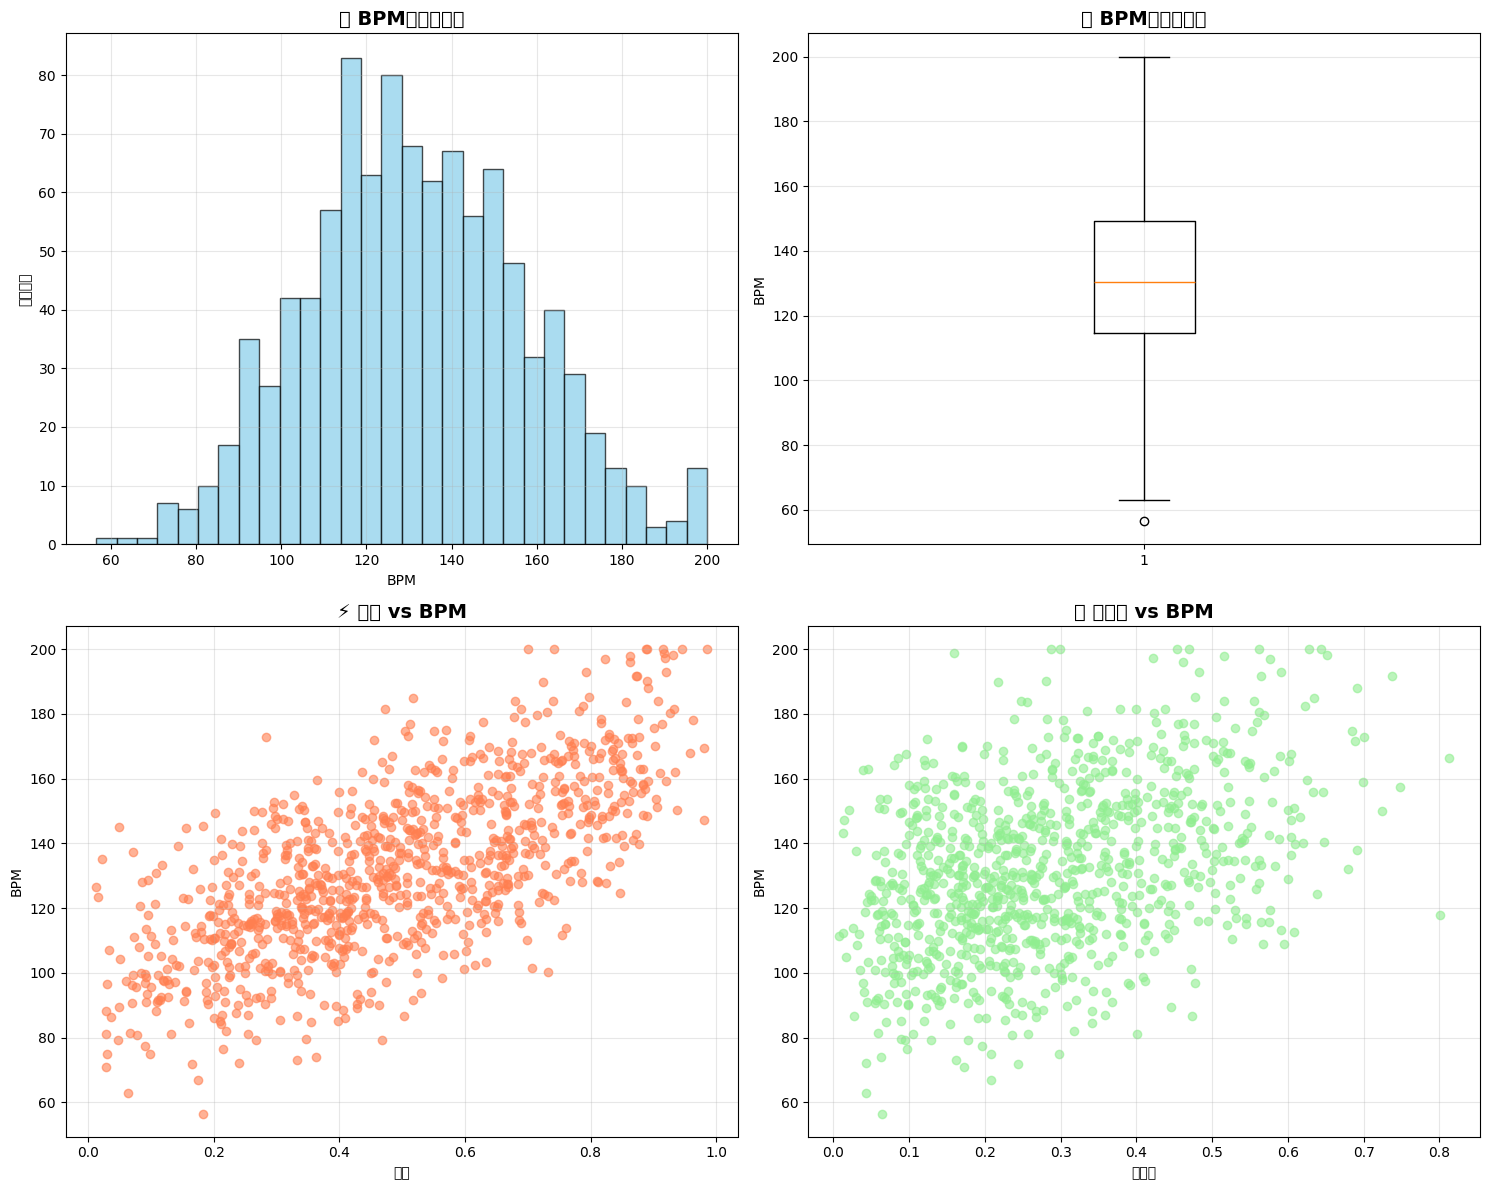

🎵 BPM统计摘要:
平均BPM: 131.6
中位数BPM: 130.3
最小BPM: 56.5
最大BPM: 200.0
标准差: 25.6


In [4]:
# BPM分布可视化
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# BPM直方图
axes[0, 0].hist(df['tempo'], bins=30, color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('🎵 BPM分布直方图', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('BPM')
axes[0, 0].set_ylabel('歌曲数量')
axes[0, 0].grid(True, alpha=0.3)

# BPM箱线图
axes[0, 1].boxplot(df['tempo'], vert=True)
axes[0, 1].set_title('📊 BPM分布箱线图', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('BPM')
axes[0, 1].grid(True, alpha=0.3)

# 能量 vs BPM散点图
axes[1, 0].scatter(df['energy'], df['tempo'], alpha=0.6, color='coral')
axes[1, 0].set_title('⚡ 能量 vs BPM', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('能量')
axes[1, 0].set_ylabel('BPM')
axes[1, 0].grid(True, alpha=0.3)

# 可舞性 vs BPM散点图
axes[1, 1].scatter(df['danceability'], df['tempo'], alpha=0.6, color='lightgreen')
axes[1, 1].set_title('💃 可舞性 vs BPM', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('可舞性')
axes[1, 1].set_ylabel('BPM')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# BPM统计信息
print("🎵 BPM统计摘要:")
print(f"平均BPM: {df['tempo'].mean():.1f}")
print(f"中位数BPM: {df['tempo'].median():.1f}")
print(f"最小BPM: {df['tempo'].min():.1f}")
print(f"最大BPM: {df['tempo'].max():.1f}")
print(f"标准差: {df['tempo'].std():.1f}")


C:\Users\admin\AppData\Local\Temp\ipykernel_15160\100431500.py:19: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\admin\AppData\Local\Temp\ipykernel_15160\100431500.py:19: UserWarning: Glyph 38899 (\N{CJK UNIFIED IDEOGRAPH-97F3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\admin\AppData\Local\Temp\ipykernel_15160\100431500.py:19: UserWarning: Glyph 20048 (\N{CJK UNIFIED IDEOGRAPH-4E50}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\admin\AppData\Local\Temp\ipykernel_15160\100431500.py:19: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\admin\AppData\Local\Temp\ipykernel_15160\100431500.py:19: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\admin\AppData\Local\Temp\ipykernel_15160\100431500.py:19: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F

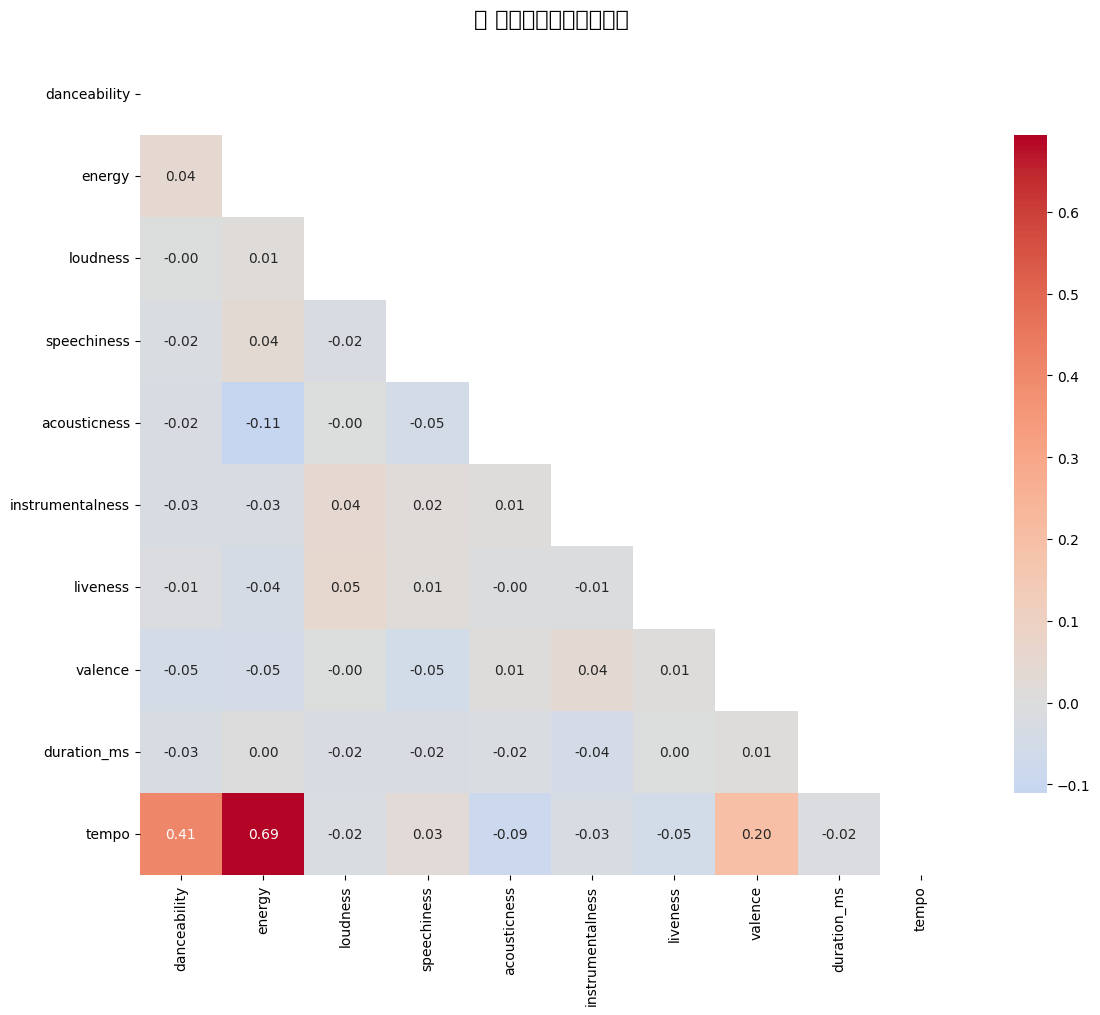

🎯 与BPM相关性排序（绝对值）:
🔥 energy         :  0.694
⚡ danceability   :  0.408
📊 valence        :  0.195
📊 acousticness   : -0.089
📊 liveness       : -0.055
📊 instrumentalness: -0.029
📊 speechiness    :  0.025
📊 loudness       : -0.018
📊 duration_ms    : -0.015

✨ 最强相关特征: energy (相关系数: 0.694)


In [5]:
# 特征相关性分析
plt.figure(figsize=(12, 10))

# 计算相关系数矩阵
correlation_matrix = df.corr()

# 创建热力图
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8})

plt.title('🔥 音乐特征相关性热力图', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# 分析与BPM最相关的特征
tempo_correlations = correlation_matrix['tempo'].sort_values(key=abs, ascending=False)
print("🎯 与BPM相关性排序（绝对值）:")
print("=" * 40)
for feature, corr in tempo_correlations.items():
    if feature != 'tempo':
        emoji = "🔥" if abs(corr) > 0.5 else "⚡" if abs(corr) > 0.3 else "📊"
        print(f"{emoji} {feature:15s}: {corr:6.3f}")
        
print(f"\n✨ 最强相关特征: {tempo_correlations.index[1]} (相关系数: {tempo_correlations.iloc[1]:.3f})")


## 📋 数据探索总结

### 🎯 我们发现了什么？

通过数据探索，我们了解到：

1. **📊 数据集规模**: 1000首歌曲，9个音乐特征
2. **🎵 BPM范围**: 从40到200 BPM，覆盖了从慢板到极快的各种音乐类型
3. **🔍 关键发现**:
   - 能量(energy)与BPM有较强的正相关关系
   - 可舞性(danceability)也与BPM显著相关
   - 情感效价(valence)对BPM有一定影响

### 🚀 下一步计划

在第三步中，我们将：

1. **🔧 数据预处理**: 
   - 处理缺失值和异常值
   - 特征标准化和归一化
   - 特征工程和选择

2. **🤖 模型构建**:
   - 尝试不同的回归模型
   - 训练和验证模型
   - 评估模型性能

3. **📈 结果优化**:
   - 超参数调优
   - 特征重要性分析
   - 模型解释性

---
**✅ 第二步：数据探索完成！**  
你现在对BPM预测任务有了清晰的理解，准备好进入建模阶段了吗？🎵
